In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert

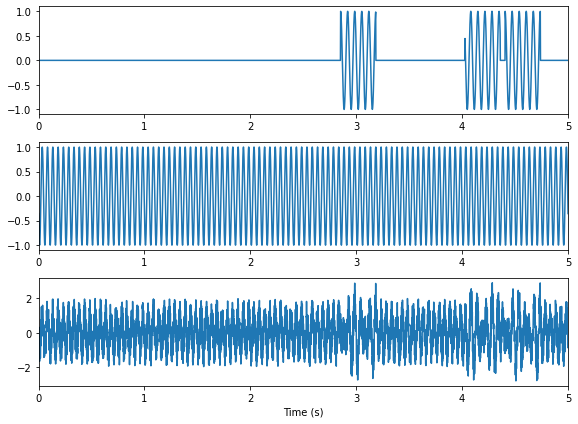

In [2]:
dt=.001
T=5
time=np.linspace(0,T,int(T/dt))
srate=1/dt

f1 = 15
f1_max_cycles=5
f1_bursts_per_trial=3
f2 = 20
w1 = 2. * np.pi * f1
w2 = 2. * np.pi * f2
signal=np.zeros((len(time)))
s1s=np.zeros((len(time)))
burst_starts=[]
burst_stops=[]
while len(burst_starts)<f1_bursts_per_trial:
    cycles=f1_max_cycles
    cycles_dur_s=cycles/f1
    dur=int(cycles_dur_s/dt)
    start=np.random.randint(int(T/dt)-dur)
    stop=start+dur
    overlap=False
    for (other_start,other_stop) in zip(burst_starts,burst_stops):
        if (start >= other_start and start < other_stop) or (stop > other_start and stop <= other_stop):
            overlap=True
            break
    if not overlap:
        s1s[start:stop]=np.sin(w1 * (time[start:stop]+np.random.randn()))
        burst_starts.append(start)
        burst_stops.append(stop)
s2=np.sin(w2 * (time+np.random.randn()))
signal=s1s+s2+np.random.uniform(-1,1,len(time))

plt.figure(figsize=(8,6))
plt.subplot(3,1,1)
plt.plot(time,s1s)
plt.xlim(time[[0,-1]])
plt.subplot(3,1,2)
plt.plot(time,s2)
plt.xlim(time[[0,-1]])
plt.subplot(3,1,3)
plt.plot(time,signal)
plt.xlim(time[[0,-1]])
plt.xlabel('Time (s)')
plt.tight_layout()

/home/bonaiuto/miniconda3/envs/new_lc/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


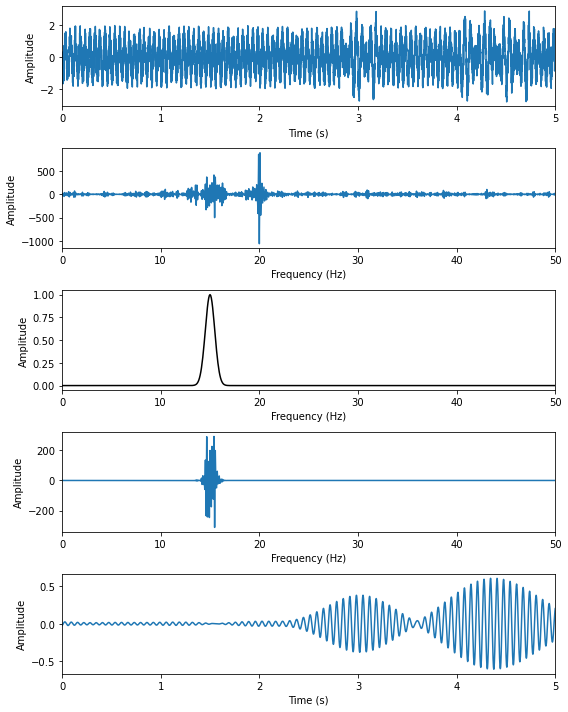

In [3]:
freqs=np.linspace(5,100,100)

# Determine the frequency resolution
df = np.diff(freqs)[0]

# Zero-pad the signal - or is mean-pad better?
padd_signal = np.hstack([np.zeros((len(time))), signal, np.zeros((len(time)))])
# Fourier transform
signal_fft = np.fft.rfft(padd_signal, axis=-1)    
fft_frex = np.fft.rfftfreq(padd_signal.shape[-1], d=1 / srate)
# Kernel width for multiplication
sigma = df * .5

freq=15

# Compute the kernel - Gaussian centered on frequency with width defined
# by requested frequency resolution
kernel = np.exp(-((fft_frex - freq) ** 2 / (2.0 * sigma ** 2)))

# Multiply Fourier-transformed signal by kernel
fsignal_fft = np.multiply(signal_fft, kernel)
# Reverse Fourier to get bandpass filtered signal
f_signal = np.fft.irfft(fsignal_fft, axis=-1)

plt.figure(figsize=(8,10))
plt.subplot(5,1,1)
plt.plot(time,signal)
plt.xlim(time[[0,-1]])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.subplot(5,1,2)
plt.plot(fft_frex,signal_fft)
plt.xlim([0,50])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')

plt.subplot(5,1,3)
plt.plot(fft_frex,kernel,'k')
plt.xlim([0,50])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')

plt.subplot(5,1,4)
plt.plot(fft_frex,fsignal_fft)
plt.xlim([0,50])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')

plt.subplot(5,1,5)
plt.plot(time,f_signal[len(time):2 * len(time)])
plt.xlim(time[[0,-1]])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.tight_layout()

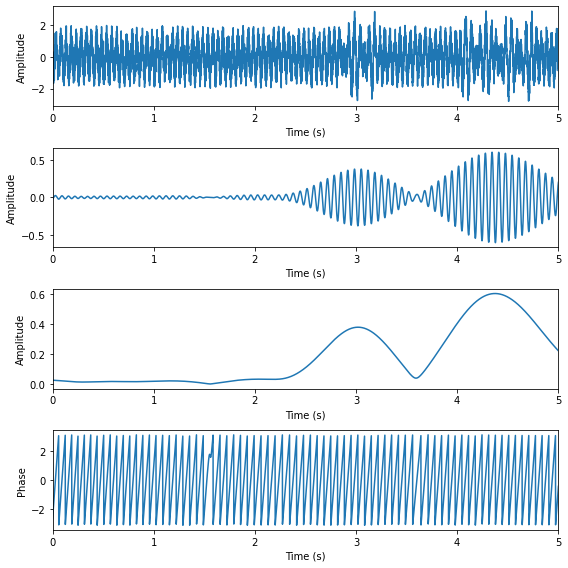

In [4]:
# Get analytic signal of bandpass filtered data (phase and amplitude)
analytic_signal = hilbert(f_signal, N=None, axis=-1)
# Cut off padding
analytic_signal=analytic_signal[len(time):2 * len(time)]

plt.figure(figsize=(8,8))
plt.subplot(4,1,1)
plt.plot(time,signal)
plt.xlim(time[[0,-1]])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.subplot(4,1,2)
plt.plot(time,f_signal[len(time):2 * len(time)])
plt.xlim(time[[0,-1]])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.subplot(4,1,3)
plt.plot(time,np.abs(analytic_signal))
plt.xlim(time[[0,-1]])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.subplot(4,1,4)
plt.plot(time,np.angle(analytic_signal))
plt.xlim(time[[0,-1]])
plt.xlabel('Time (s)')
plt.ylabel('Phase')


plt.tight_layout()

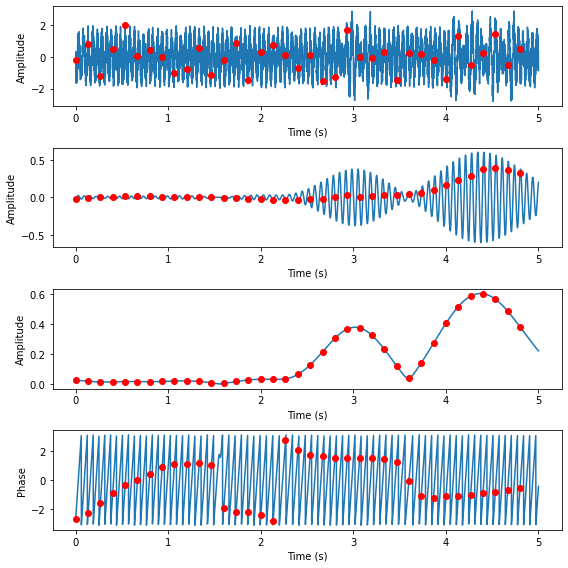

In [5]:
lag=2

# Duration of this lag in s
lag_dur_ms = lag * 1 / freq
# Number of evaluations
n_evals = int(np.floor(T / lag_dur_ms))
# Remaining time
diff = T - (n_evals * lag_dur_ms)

# Start time
start_time = time[0]
# Evaluation times (ms)
eval_times = np.linspace(start_time, T - diff, n_evals + 1)[:-1]
# Evaluation time points
eval_pts = np.searchsorted(time, eval_times)


plt.figure(figsize=(8,8))
plt.subplot(4,1,1)
plt.plot(time,signal)
plt.plot(eval_times,signal[eval_pts],'ro')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.subplot(4,1,2)
plt.plot(time,f_signal[len(time):2 * len(time)])
plt.plot(eval_times,f_signal[len(time)+eval_pts],'ro')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.subplot(4,1,3)
plt.plot(time,np.abs(analytic_signal))
plt.plot(eval_times,np.abs(analytic_signal[eval_pts]),'ro')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.subplot(4,1,4)
plt.plot(time,np.angle(analytic_signal))
plt.plot(eval_times,np.angle(analytic_signal[eval_pts]),'ro')
plt.xlabel('Time (s)')
plt.ylabel('Phase')

plt.tight_layout()

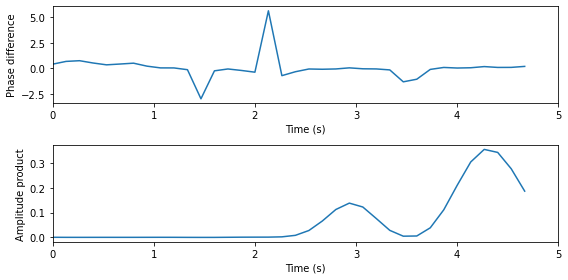

In [6]:
# Analytic signal at m=0...n_evals-1 evaluation points, and n=0..n_range time points in between
f1 = analytic_signal[eval_pts[:-1]]
# Analytic signal at m=1...n_evals evaluation points, and n=0..n_range time points in between
f2 = analytic_signal[eval_pts[1:]]
# calculate the phase difference and amplitude product
phase_diff = np.angle(f2) - np.angle(f1)
amp_prod=np.abs(f1) * np.abs(f2)

plt.figure(figsize=(8,4))
plt.subplot(2,1,1)
plt.plot(eval_times[:-1],phase_diff)
plt.xlim(time[[0,-1]])
plt.xlabel('Time (s)')
plt.ylabel('Phase difference')

plt.subplot(2,1,2)
plt.plot(eval_times[:-1],amp_prod)
plt.xlim(time[[0,-1]])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude product')

plt.tight_layout()


In [7]:
# Numerator - sum is over evaluation points
num = np.abs(np.sum(amp_prod * np.exp(complex(0, 1) * phase_diff), axis=-1))
print(num)

2.406742241632686


In [8]:
# Scaling factor - sum is over evaluation points
denom = np.sqrt(np.sum(np.abs(np.power(f1, 2)), axis=-1) * np.sum(np.abs(np.power(f2, 2)), axis=-1))
print(denom)


2.4916333601041716


In [9]:
lc = num / denom
print(lc)

0.9659295304715552
